In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Image Processing with Neural Network

## Assignment A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- Activation function of your choice
- Regularization:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping.
    
- multi-class output
- Fashion MNIST dataset

In [4]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [5]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd
import sys
import numpy as np
from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [6]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

EPOCHS = 200
ALPHA = .001
TEST_SIZE = .2
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5
BATCH_SIZE = 256
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
torch.manual_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## All about CUDA

In [8]:
# print ('Is CUDA available: ', torch.cuda.is_available())

# print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

In [9]:
# torch.cuda.get_device_name(torch.cuda.current_device()) # to se which gpu we are running

In [10]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [11]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [12]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [13]:
train_df['label'] = pd.to_numeric(train_df['label'], downcast = 'integer')
test_df['label'] = pd.to_numeric(test_df['label'], downcast = 'integer')
X_train = train_df.drop('label', axis = 1).to_numpy()
X_test = train_df.label

X_train, X_test, y_train, y_test = train_test_split(X_train, X_test, test_size = TEST_SIZE, stratify = X_test, random_state = RANDOM_STATE)

train_shape = X_train.shape

In [14]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# custom datasets

In [16]:
'''define custom dataset'''
class AmnistDataset(Dataset):
    def __init__(self, X, y):
        super(AmnistDataset, self).__init__()
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


    
    

In [17]:
train_dataset = AmnistDataset(X_train, y_train)

In [18]:
train_loader =  DataLoader(dataset = train_dataset, # just like cache.prefectch which we used to feth mini batch in tensor
                        shuffle =True,
                        batch_size = BATCH_SIZE, )

# X_batch, y_batch = next(iter(train_loader))
# X_batch.shape, y_batch.shape

In [19]:
test_dataset = AmnistDataset(X_test, y_test.tolist())

test_loader =  DataLoader(dataset = test_dataset,
                        shuffle =True,
                        batch_size = BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256]))

In [20]:
X_train.shape, y_train.shape

((48000, 784), (48000,))

In [21]:
## preparing model

In [22]:
input_dim = X_train.shape[1]

class Model(nn.Module): #nn.Module is pytorch class, we are extending it
    def __init__(self, input_dim):
        super(Model, self).__init__() #callling parent class constructot
        dor1= .4
        dor2 = .5
        self.layer1 = nn.Linear(input_dim, 196) # incoming layer = input_dim no of neurons outgoing layer =196 no of neurons
        self.actv1 = nn.ReLU() # activation_function
        self.do1 = nn.Dropout(dor1) ## dropout layer
        self.bn1 = nn.BatchNorm1d(196) # batchnorm1d for 1d arrays
        
        self.layer2 = nn.Linear(196, 98)
        self.actv2 = nn.ReLU()
        self.do2 = nn.Dropout(dor2) ## dropout layer
        self.bn2 = nn.BatchNorm1d(98) # batchnorm1d for 1d arrays
        
        self.layer3 = nn.Linear(98, 10)

    def forward(self, x): # forward propagation
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.do1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.do2(x)
        x = self.layer3(x)
        return x

model = Model(input_dim).to(device = device)
print(model)
    



# model = nn.Sequential(nn.Linear(input_dim, 196),
#                       nn.ReLU(),
#                       nn.Linear(196, 98),
#                       nn.ReLU(),
#                       nn.Linear(98, 10)).to(device = device)

Model(
  (layer1): Linear(in_features=784, out_features=196, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=196, out_features=98, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=98, out_features=10, bias=True)
)


In [23]:
summary(model, input_size=(input_dim,))
# summary(model, (1,input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 196]         153,860
              ReLU-2                  [-1, 196]               0
           Dropout-3                  [-1, 196]               0
       BatchNorm1d-4                  [-1, 196]             392
            Linear-5                   [-1, 98]          19,306
              ReLU-6                   [-1, 98]               0
       BatchNorm1d-7                   [-1, 98]             196
           Dropout-8                   [-1, 98]               0
            Linear-9                   [-1, 10]             990
Total params: 174,744
Trainable params: 174,744
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.67
Estimated Total Size (MB): 0.68
-------------------------------------------

In [24]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([196, 784])
torch.Size([196])
torch.Size([196])
torch.Size([196])
torch.Size([98, 196])
torch.Size([98])
torch.Size([98])
torch.Size([98])
torch.Size([10, 98])
torch.Size([10])


In [25]:
# [196, 784] weight shape for layer 1
# similarly torch.Size([196]) : bias shape for layer 1 and so on 

In [26]:
train_X = torch.tensor(X_train, dtype = torch.float32, device = device)
train_y = torch.tensor(y_train, dtype = torch.int64, device = device)


test_X = torch.tensor(X_test, dtype = torch.float32, device = device)
test_y = torch.tensor(y_test.tolist(), dtype = torch.int64, device = device)

In [27]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = LR_FACTOR,
                                                       patience = LR_PATIENCE,
                                                       min_lr = 1e-5) # the min_lr parameter specifies the minimum learning rate the optimizer is allowed to use. This acts as a lower bound for the learning rate during the training process.

chkptPath = os.path.join(modelDir, subDir, 'all_in_torch.keras')
# loss = []
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []
patience = 0
miin = float('inf')

for epoch in range(EPOCHS):
    model.train()
    epoch_acc, epoch_loss = 0, 0
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X, train_y = train_X.to(device), train_y.to(device)
        predict_proba = model(train_X)
        batch_loss = loss_fn(predict_proba, train_y)
        
        # Update running mean for loss
        epoch_loss += (batch_loss.item() - epoch_loss) / (batch_idx + 1)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        y_pred = predict_proba.argmax(dim=1)
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc) / (batch_idx + 1)
    
    loss.append(epoch_loss)
    acc.append(epoch_acc)
    
    model.eval()
    tepoch_loss, tepoch_acc = 0, 0
    with torch.no_grad():  # No gradients during validation
        for batch_idx, (test_X, test_y) in enumerate(test_loader):
            test_X, test_y = test_X.to(device), test_y.to(device)
            test_proba = model(test_X)
            batch_loss = loss_fn(test_proba, test_y)
            tepoch_loss += (batch_loss.item() - tepoch_loss) / (batch_idx + 1)
            
            y_pred = test_proba.argmax(dim=1).cpu().numpy()
            batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
            tepoch_acc += (batch_acc - tepoch_acc) / (batch_idx + 1)
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss)
    n_epoch.append(epoch)
    
    # Scheduler step
    scheduler.step(tepoch_loss)
    
    # Early stopping
    if tepoch_loss < miin:
        print(f'Loss improved from {miin:.5f} to {tepoch_loss:.5f}')
        miin = tepoch_loss
        patience = 0 
        torch.save(model.state_dict(), chkptPath)
        
    else:
        patience += 1
        print(f'Loss did not improve from {miin:.5f}. Current: {tepoch_loss:.5f}')
        if patience == PATIENCE:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    if epoch % 5 == 0 or tepoch_loss < miin:
        print("----------------------------------------------------------------------------------------------------------------------------------------------------")
        print(f'Epoch {epoch:>5d} | Loss: {epoch_loss:.5f}/{tepoch_loss:.5f} | ACC: {epoch_acc:.5f}/{tepoch_acc:.5f}')
        print(f'LR: {scheduler.get_last_lr()[0]:.5f}')
        print("----------------------------------------------------------------------------------------------------------------------------------------------------")


Loss improved from inf to 0.42780
----------------------------------------------------------------------------------------------------------------------------------------------------
Epoch     0 | Loss: 0.67577/0.42780 | ACC: 0.77213/0.84491
LR: 0.00100
----------------------------------------------------------------------------------------------------------------------------------------------------
Loss improved from 0.42780 to 0.38243
Loss improved from 0.38243 to 0.36903
Loss improved from 0.36903 to 0.35579
Loss improved from 0.35579 to 0.34748
Loss improved from 0.34748 to 0.33428
----------------------------------------------------------------------------------------------------------------------------------------------------
Epoch     5 | Loss: 0.36593/0.33428 | ACC: 0.87120/0.88066
LR: 0.00100
----------------------------------------------------------------------------------------------------------------------------------------------------
Loss improved from 0.33428 to 0.33305


In [28]:
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = LR_FACTOR,
#                                                        patience = LR_PATIENCE,
#                                                        min_lr = 1e-5) # the min_lr parameter specifies the minimum learning rate the optimizer is allowed to use. This acts as a lower bound for the learning rate during the training process.


# loss = []
# tloss, n_epoch, acc, tacc = [],[],[],[]
# patience = 0
# miin = float('inf')

# for epoch in range(EPOCHS):
#     model.train() # set your model in train mode
#     epoch_acc, epoch_loss, tepoch_loss, tepoch_acc = 0,0,0, 0
#     for batch_idx, (train_X, train_y) in enumerate(train_loader): # doing mini batch 
#         train_X = train_X.to(device)
#         train_y = train_y.to(device)
#         predict_proba = model(train_X)
#         batch_loss = loss_fn(predict_proba, train_y) # calculate loss
#         epoch_loss += (batch_loss - epoch_loss)/(batch_idx + 1) # calculate runing mean or ---> average of all the batch losses till now is epoch loss
    
#         optimizer.zero_grad()
#         batch_loss.backward()
#         optimizer.step()
#         y_pred = predict_proba.argmax(dim = 1)
#         batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
#         epoch_acc += (batch_acc - epoch_acc) / (batch_idx + 1)

    
#     loss.append(epoch_loss.data.item())
#     acc.append(epoch_acc)
#     model.eval() # Set your model in eval mode
#     for batch_idx, (test_X, test_y) in enumerate (test_loader):
#         test_X, test_y= test_X.to(device), test_y.to(device)
#         test_proba = model(test_X) # make prediction
#         batch_loss = loss_fn (test_proba, test_y) # Calculate loss
#         tepoch_loss +=(batch_loss - tepoch_loss)/(batch_idx+1) # Calculate running mean
#         y_pred= test_proba.argmax(dim=1).cpu().numpy()
#         batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
#         tepoch_acc += (batch_acc- tepoch_acc)/ (batch_idx+1) # Calculate running mean

#     tacc.append(tepoch_acc)
#     tloss.append(tepoch_loss.data.item())
#     n_epoch.append(epoch)
#     # LR Reudction strp
#     scheduler.step(tepoch_loss) # write this after model.train() and model.eval() , scheduler takes a step keeping test loss in  mind



#     # if epoch % 10 ==0:
#     #     print(f'Epoch: {epoch:>5d} |Loss: {epoch_loss:.5f}/{tepoch_loss:.5f} | ACC: {epoch_acc: .5f}/{tepoch_acc: .5f}')
#     #     print(f'Acc: {epoch_acc:.5f} | {tepoch_acc:.5f}')
#     #     print(f'LR: {scheduler.get_last_lr()[0]:.5f}')


#     if tepoch_loss < miin:
#         print(f'loss improved from {miin} to {tepoch_loss}')
#         miin = tepoch_loss
#         patience = 0
#         print('-------------------------------------------------------------------------------------------------------------------------------------------------------')
#     else:
#         patience += 1
#         print(f'loss did not improve from {miin}. current:-  {tepoch_loss}')
#         if patience == PATIENCE:
#             break

#     print(f'Epoch: {epoch:>5d} |Loss: {epoch_loss:.5f}/{tepoch_loss:.5f} | ACC: {epoch_acc: .5f}/{tepoch_acc: .5f}')
#     print(f'Acc: {epoch_acc:.5f} | {tepoch_acc:.5f}')
#     print(f'LR: {scheduler.get_last_lr()[0]:.5f}')

In [29]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_Acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_Acc
0,0,0.675770,0.427795,0.772128,0.844914
1,1,0.468124,0.382430,0.836665,0.861334
2,2,0.425450,0.369028,0.849505,0.863044
3,3,0.399840,0.355789,0.859126,0.867354
4,4,0.377966,0.347480,0.865858,0.872898


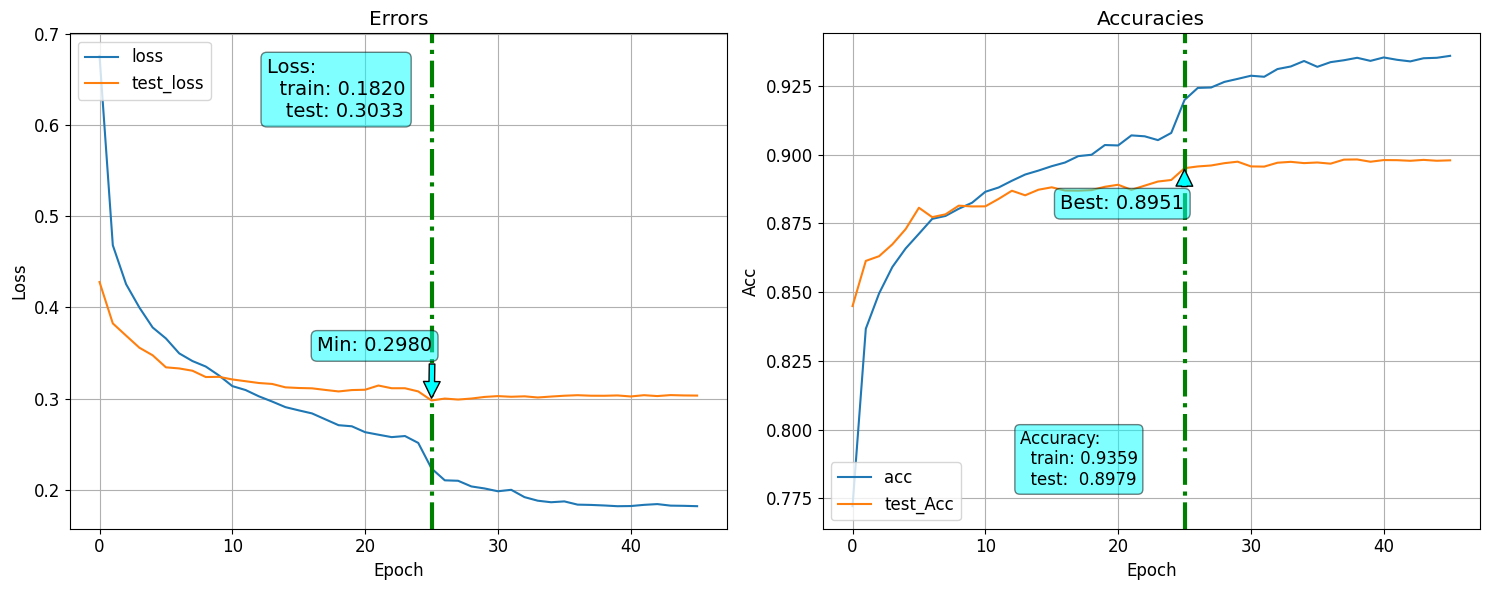

In [30]:
fn_plot_torch_hist(loss_df)

In [31]:
outputs = model.load_state_dict(torch.load(chkptPath, weights_only=True))
outputs

<All keys matched successfully>

In [32]:
outputs(test_y)

TypeError: '_IncompatibleKeys' object is not callable

In [ ]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

In [ ]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

In [ ]:
y_pred = []

In [ ]:
for batch_idx, (test_X, test_y) in enumerate(test_loader):
    
    y_pred.extend(torch.argmax(outputs, dim = 1).list())

In [ ]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).list()
y_pred

In [ ]:
y_true= train_y.numpy()
print(classification_report(y_true, y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

### on test data

In [ ]:
outputs = model(test_X)
outputs

In [ ]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

In [ ]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

In [ ]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).numpy()
y_pred

In [ ]:
outputs = model(test_X)
outputs

In [ ]:
type(outputs.cpu()) #.cpu() to bring it to cpu our is already on cpu

In [ ]:
type(outputs.cpu().detach().numpy()) # did detach to detach from transformation : grad_fn=<AddmmBackward0>)
 # This means that the tensor is treated as a constant and no gradients will be calculated for it during backpropagation.

In [ ]:
# outputs = model(train_X)
y_pred = torch.argmax(outputs, dim = 1).numpy()
y_pred

In [ ]:
y_true= test_y.numpy()
print(classification_report(y_true, y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)